# BARBIN Kevin BERNARD Felix TEPEDELEN Léo

# Projet Atelier Intégration des Données Datawarehouse Openfoodfacts

Ce notebook Python est le rapport détaillé et l'ETL de notre projet. La suite du rapport se situe après l'ETL, nous y détaillons le fonctionnement du reste du système.

Il a été réalisé à l'aide de Docker afin d'en faciliter le déploiement pour tester et collaborer.

Vous trouverez tout ce qu'il vous faut pour essayer le programme sur votre machine dans le fichier README de ce repository github :

https://github.com/bambouzelle/openfoodfact

# Extraire les données dans un DataFrame pySpark

In [1]:
from pyspark.sql import SparkSession

# Créer une session Spark
spark = SparkSession.builder.appName("example").getOrCreate()

# Lire le fichier CSV
df = spark.read.option("sep", "\t").csv("data/en.openfoodfacts.org.products.csv.gz", header=True, inferSchema=True).cache()

In [19]:
print("Nombre de lignes dans le fichier de base : " + str(df.count()))

Nombre de lignes dans le fichier de base : 3417378


# Générer une table au format CSV avec une description statistique du DataFrame

In [ ]:
df.describe().toPandas().to_csv("describe_summary.csv", index=False)

# Effectuer un échantillonage du DataFrame pour en observer les colonnes qui peuvent sembler pertinentes

In [5]:
FRACTION_SIZE = 0.00001

In [6]:
columnsToSample = ['quantity', 'serving_size', 'serving_quantity', 'product_quantity']

In [7]:
samples_not_clean_df = df.select(columnsToSample).dropna(how='all').cache()

In [8]:
samples_df = samples_not_clean_df.sample(withReplacement=False, fraction=FRACTION_SIZE).cache()

In [9]:
samples_df.count()

16

In [10]:
samples_df.show()

+--------+-----------------+----------------+----------------+
|quantity|     serving_size|serving_quantity|product_quantity|
+--------+-----------------+----------------+----------------+
|    NULL|           354.0g|           354.0|            NULL|
|   14 oz|             NULL|            NULL|    396.89332375|
|    NULL|   8 OZA (240 ml)|           240.0|            NULL|
|   105 g|             40 g|            40.0|           105.0|
|    NULL|            27.0g|            27.0|            NULL|
|    NULL|1 PACKAGE (124 g)|           124.0|            NULL|
|    NULL|   1 SLICE (28 g)|            28.0|            NULL|
|    NULL| 0.5 cup (120 ml)|           120.0|            NULL|
|    NULL|   1/4 cup (30 g)|            30.0|            NULL|
|    227g|             NULL|            NULL|           227.0|
|    NULL|            100 g|           100.0|            NULL|
|   275 g|             NULL|            NULL|           275.0|
|   160 g|             30 g|            30.0|          

# Extraire les valeurs uniques d'une colonne afin d'en confirmer la pertinence (colonne ingredients_analysis_tags en exemple)

In [11]:
def flatten_list(li):
    flat_list = []
    for row in li:
        flat_list += row
    return flat_list

def make_list_unique(li):
    return list(dict.fromkeys(li))

def split_string_list_elements(li, sep):
    return [x.split(sep) for x in li]

def column_to_list(col):
    return col.rdd.flatMap(lambda x: x).collect()

In [12]:
ingredients_analysis_list = make_list_unique(flatten_list(split_string_list_elements(column_to_list(df.select('ingredients_analysis_tags').dropna()), ",")))

In [14]:
ingredients_analysis_list

['en:palm-oil-free',
 'en:non-vegan',
 'en:vegetarian-status-unknown',
 'en:palm-oil-content-unknown',
 'en:vegan-status-unknown',
 'en:may-contain-palm-oil',
 'en:vegetarian',
 'en:vegan',
 'en:non-vegetarian',
 'en:palm-oil',
 'en:maybe-vegan',
 'en:maybe-vegetarian']

# Sélection des colonnes nécessaires après étude de celles-ci

In [27]:
kept_columns = ["code", "product_name", "product_quantity", "energy-kcal_100g", "fat_100g", "saturated-fat_100g", "monounsaturated-fat_100g", "polyunsaturated-fat_100g", "trans-fat_100g", 
                "carbohydrates_100g", "sugars_100g", "starch_100g", "fiber_100g", "proteins_100g", "allergens", "traces", "vitamin-a_100g", "vitamin-c_100g", "vitamin-d_100g",
                "vitamin-e_100g", "vitamin-k_100g", "vitamin-b1_100g", "vitamin-b2_100g", "vitamin-b6_100g", "vitamin-b9_100g", "vitamin-b12_100g", "calcium_100g",
                "iron_100g", "magnesium_100g", "potassium_100g", "zinc_100g", "food_groups_tags", "serving_size", "serving_quantity", "cholesterol_100g", "salt_100g", "glycemic-index_100g"]

In [28]:
df_kept_columns = df.select(kept_columns)

# Qualité des données

## On supprime les lignes qui ont moins de 15 colonnes très pertinentes non nulles

In [29]:
columns_to_check = ["code", "product_name", "product_quantity", "energy-kcal_100g", "fat_100g", "saturated-fat_100g", "monounsaturated-fat_100g",
                    "polyunsaturated-fat_100g", "trans-fat_100g", "carbohydrates_100g", "sugars_100g", "starch_100g", 
                    "fiber_100g", "proteins_100g", "allergens", "traces", "food_groups_tags", "serving_size", "serving_quantity"]

In [30]:
df_kept_columns = df_kept_columns.dropna(subset=columns_to_check, thresh=15)

## On supprime les lignes dupliquées et on garde le DF en cache pour éviter de le recalculer

In [31]:
df_kept_columns = df_kept_columns.dropDuplicates().cache()

In [32]:
print("Nombre de lignes restantes après le traitement : " + str(df_kept_columns.count()))

Nombre de lignes restantes après le traitement : 65552


## Plus besoin du DataFrame de base donc on le retire de la mémoire cache

In [33]:
df.unpersist()
print("Mémoire libérée")

Mémoire libérée


# Écriture des données nettoyées en base de données avec le driver JDBC

In [34]:
properties = {
    "user": "user",
    "password": "userpassword",
    "driver": "com.mysql.cj.jdbc.Driver"
}

df_kept_columns.write.jdbc(url="jdbc:mysql://mysql:3306/openfoodfact", table="products", mode="append", properties=properties)

# Suite du rapport

## Schéma de la BDD du Datawarehouse

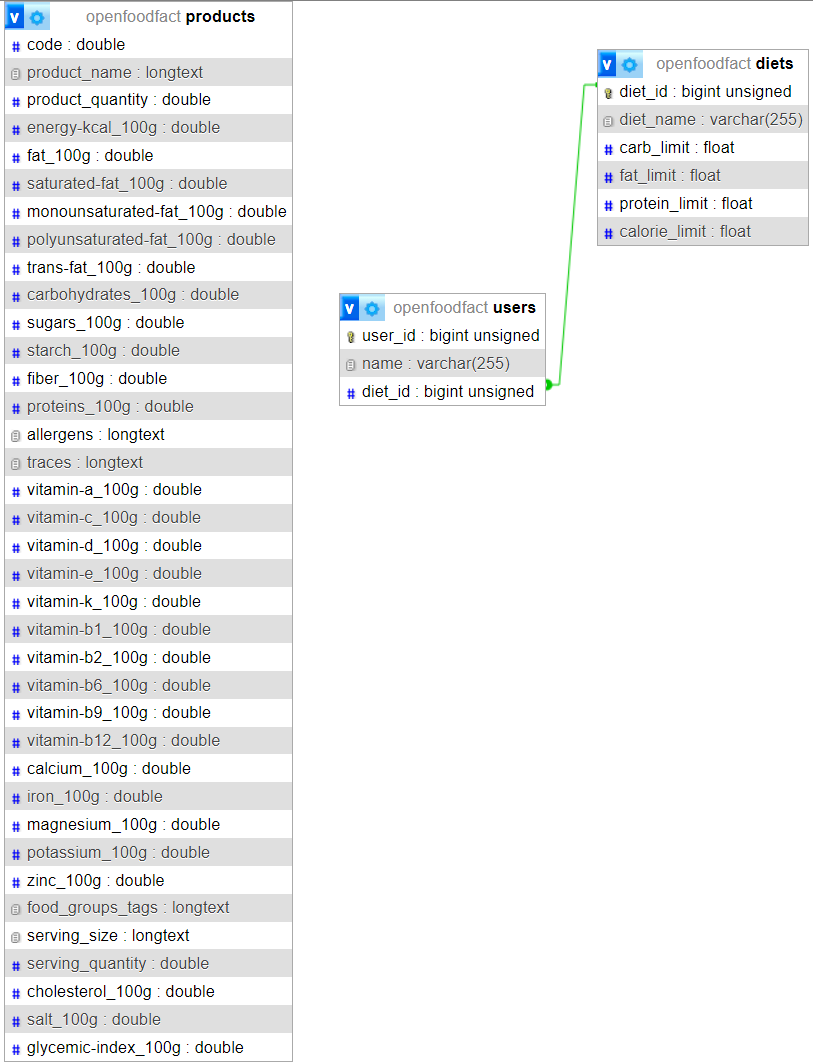

## Script qui s'exécute automatiquement avec le docker-compose qui génère le schéma et remplit les tables users et diets

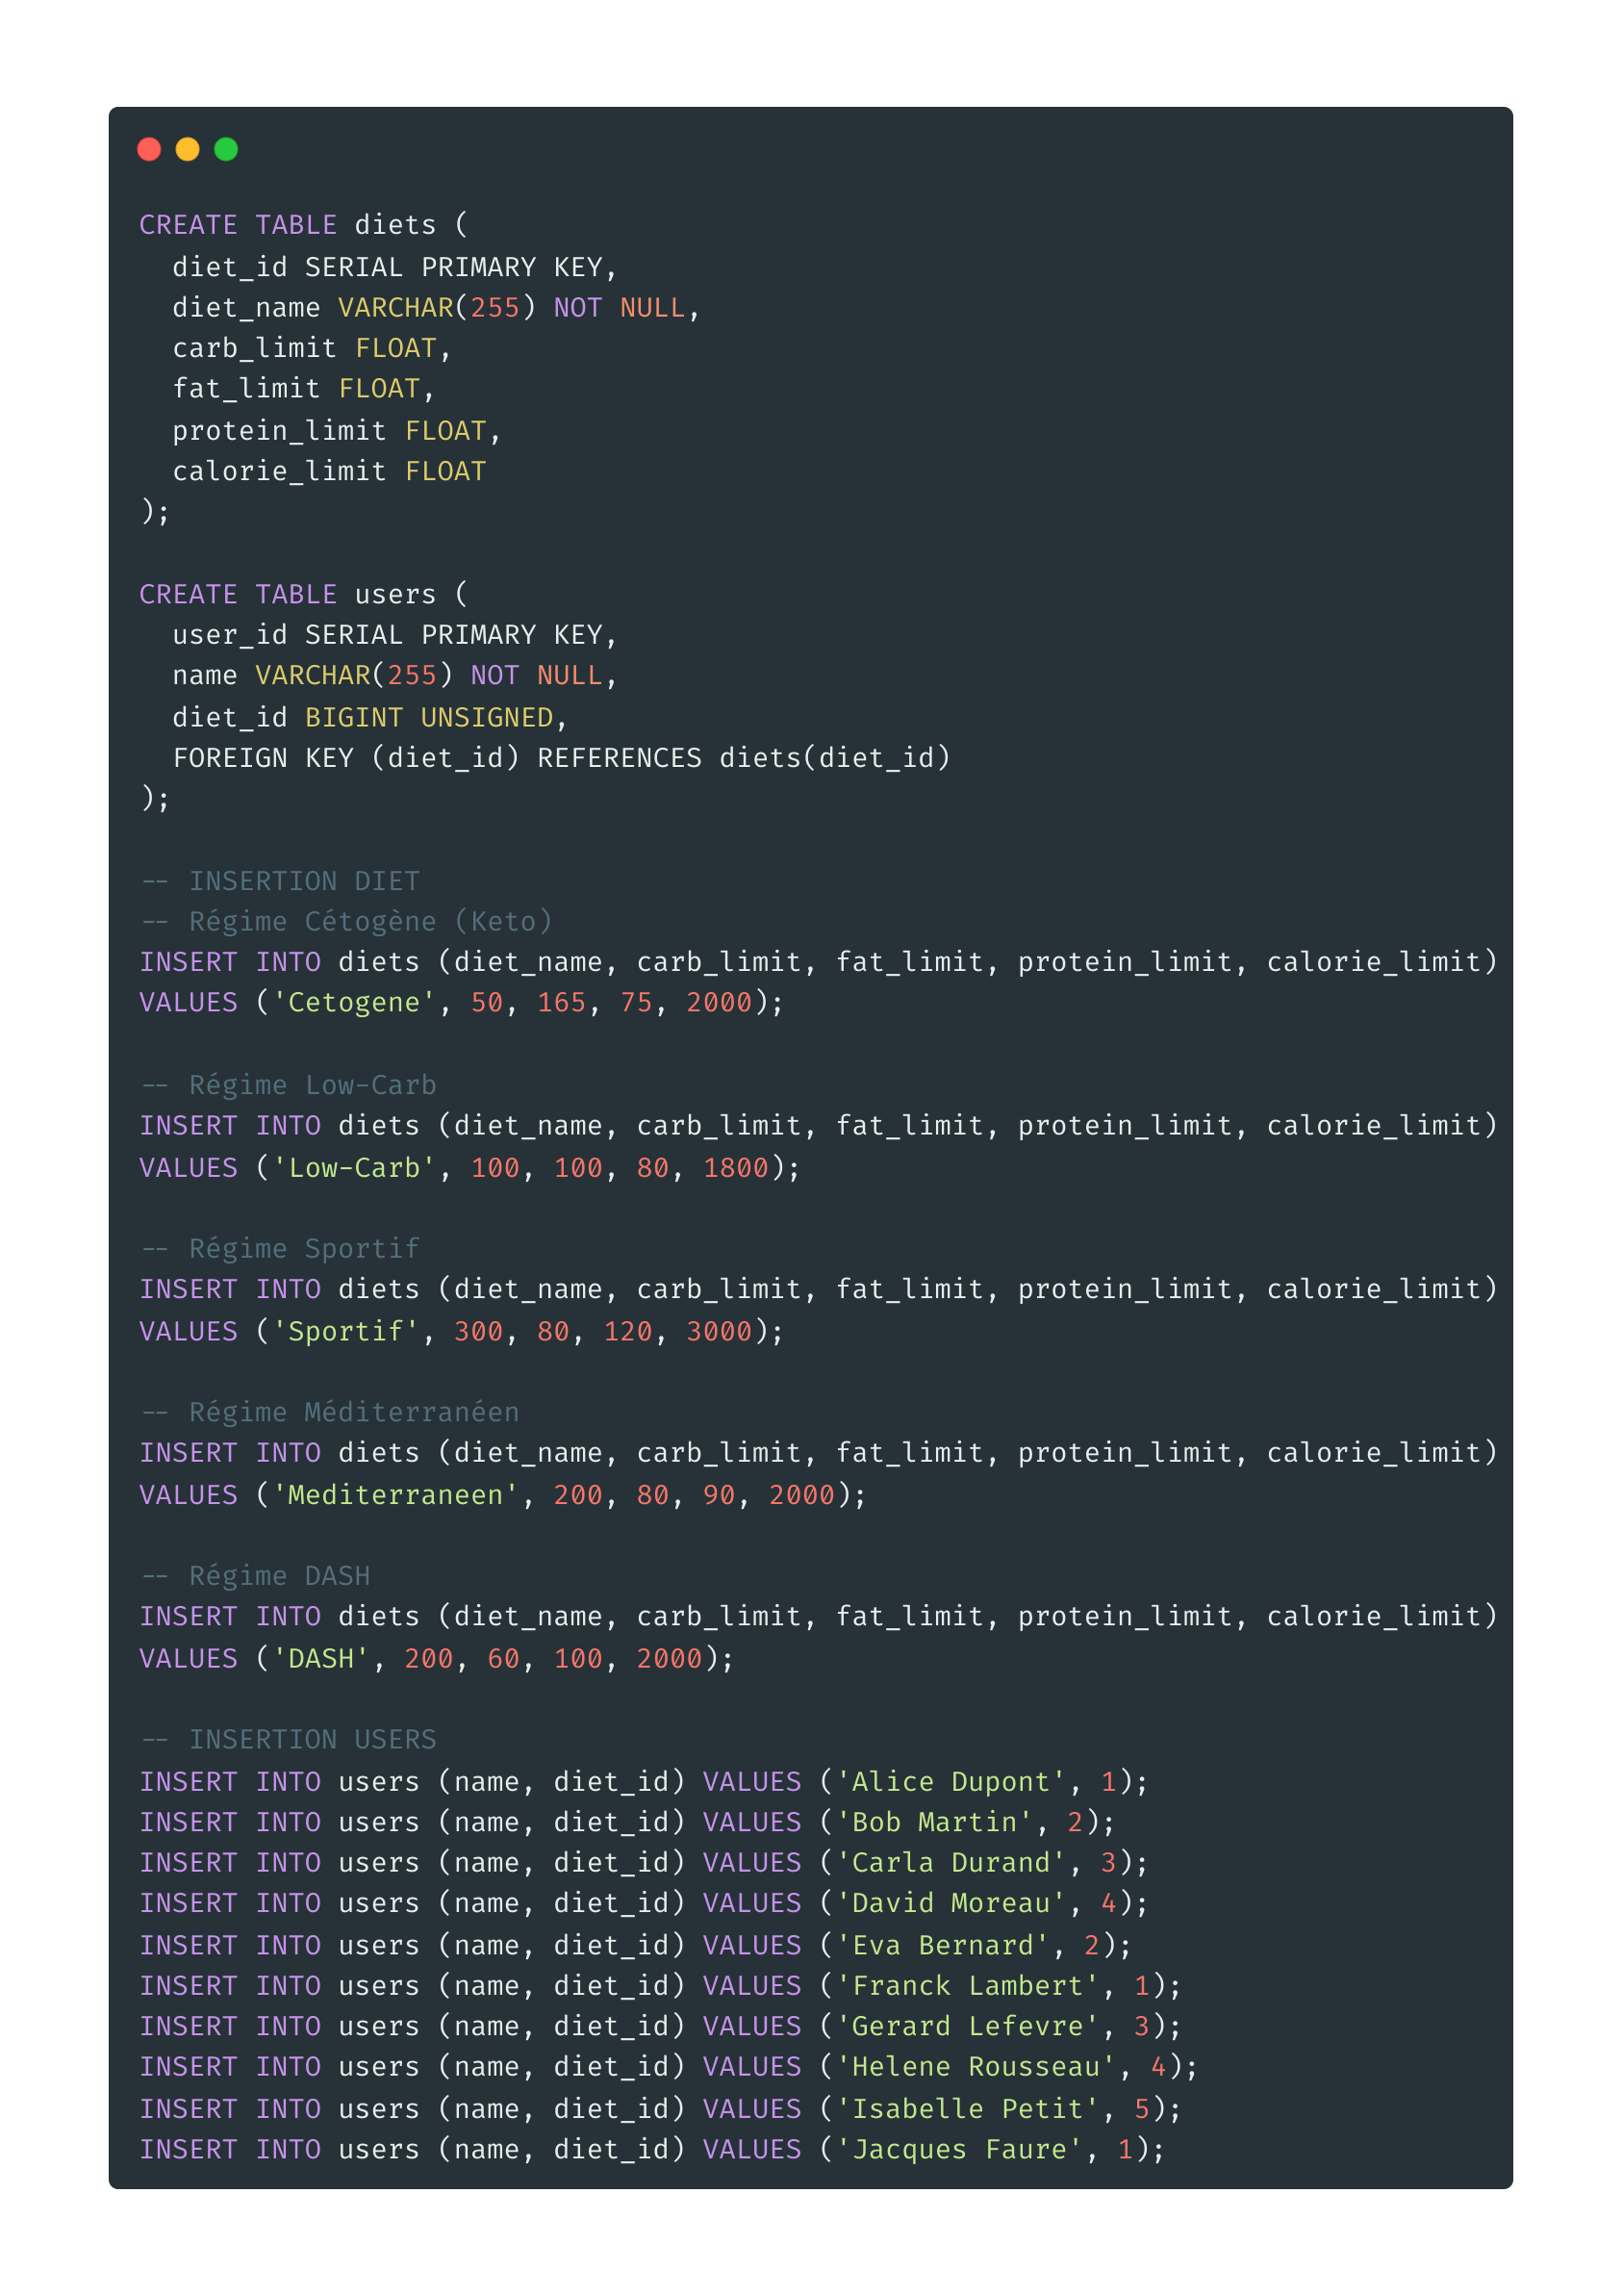

## Config Docker

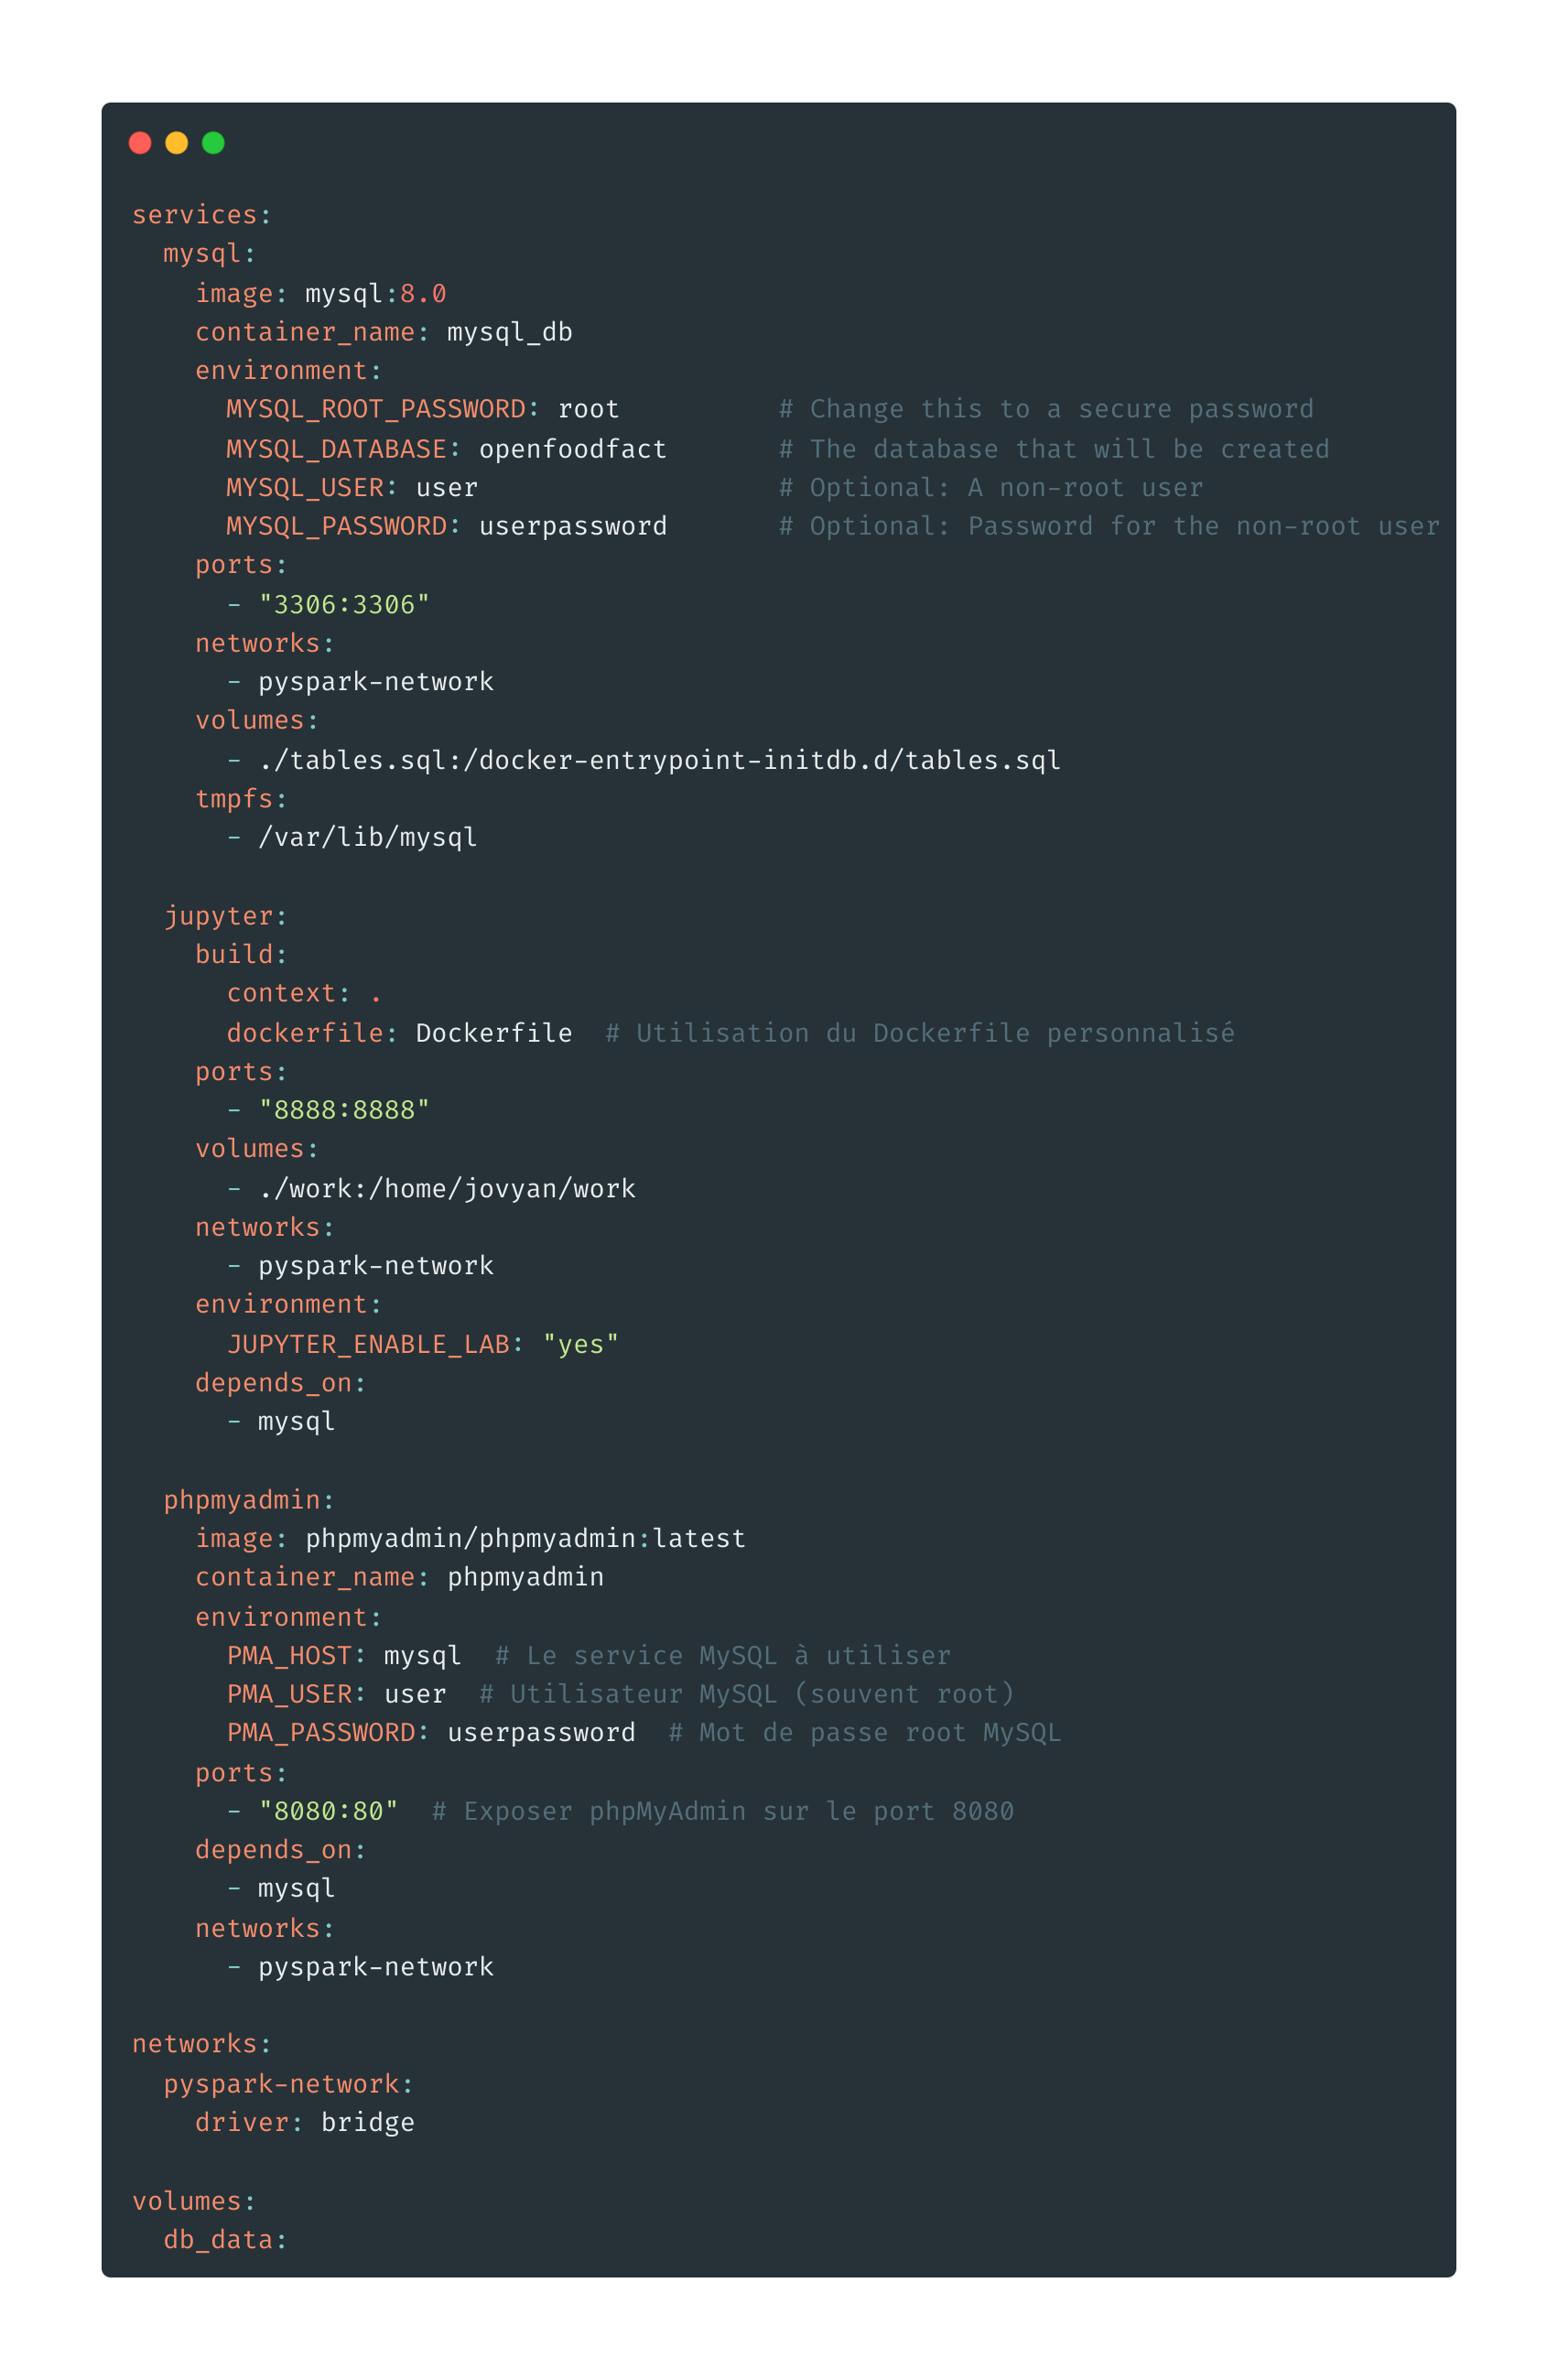

## Script pour générer des menus simples

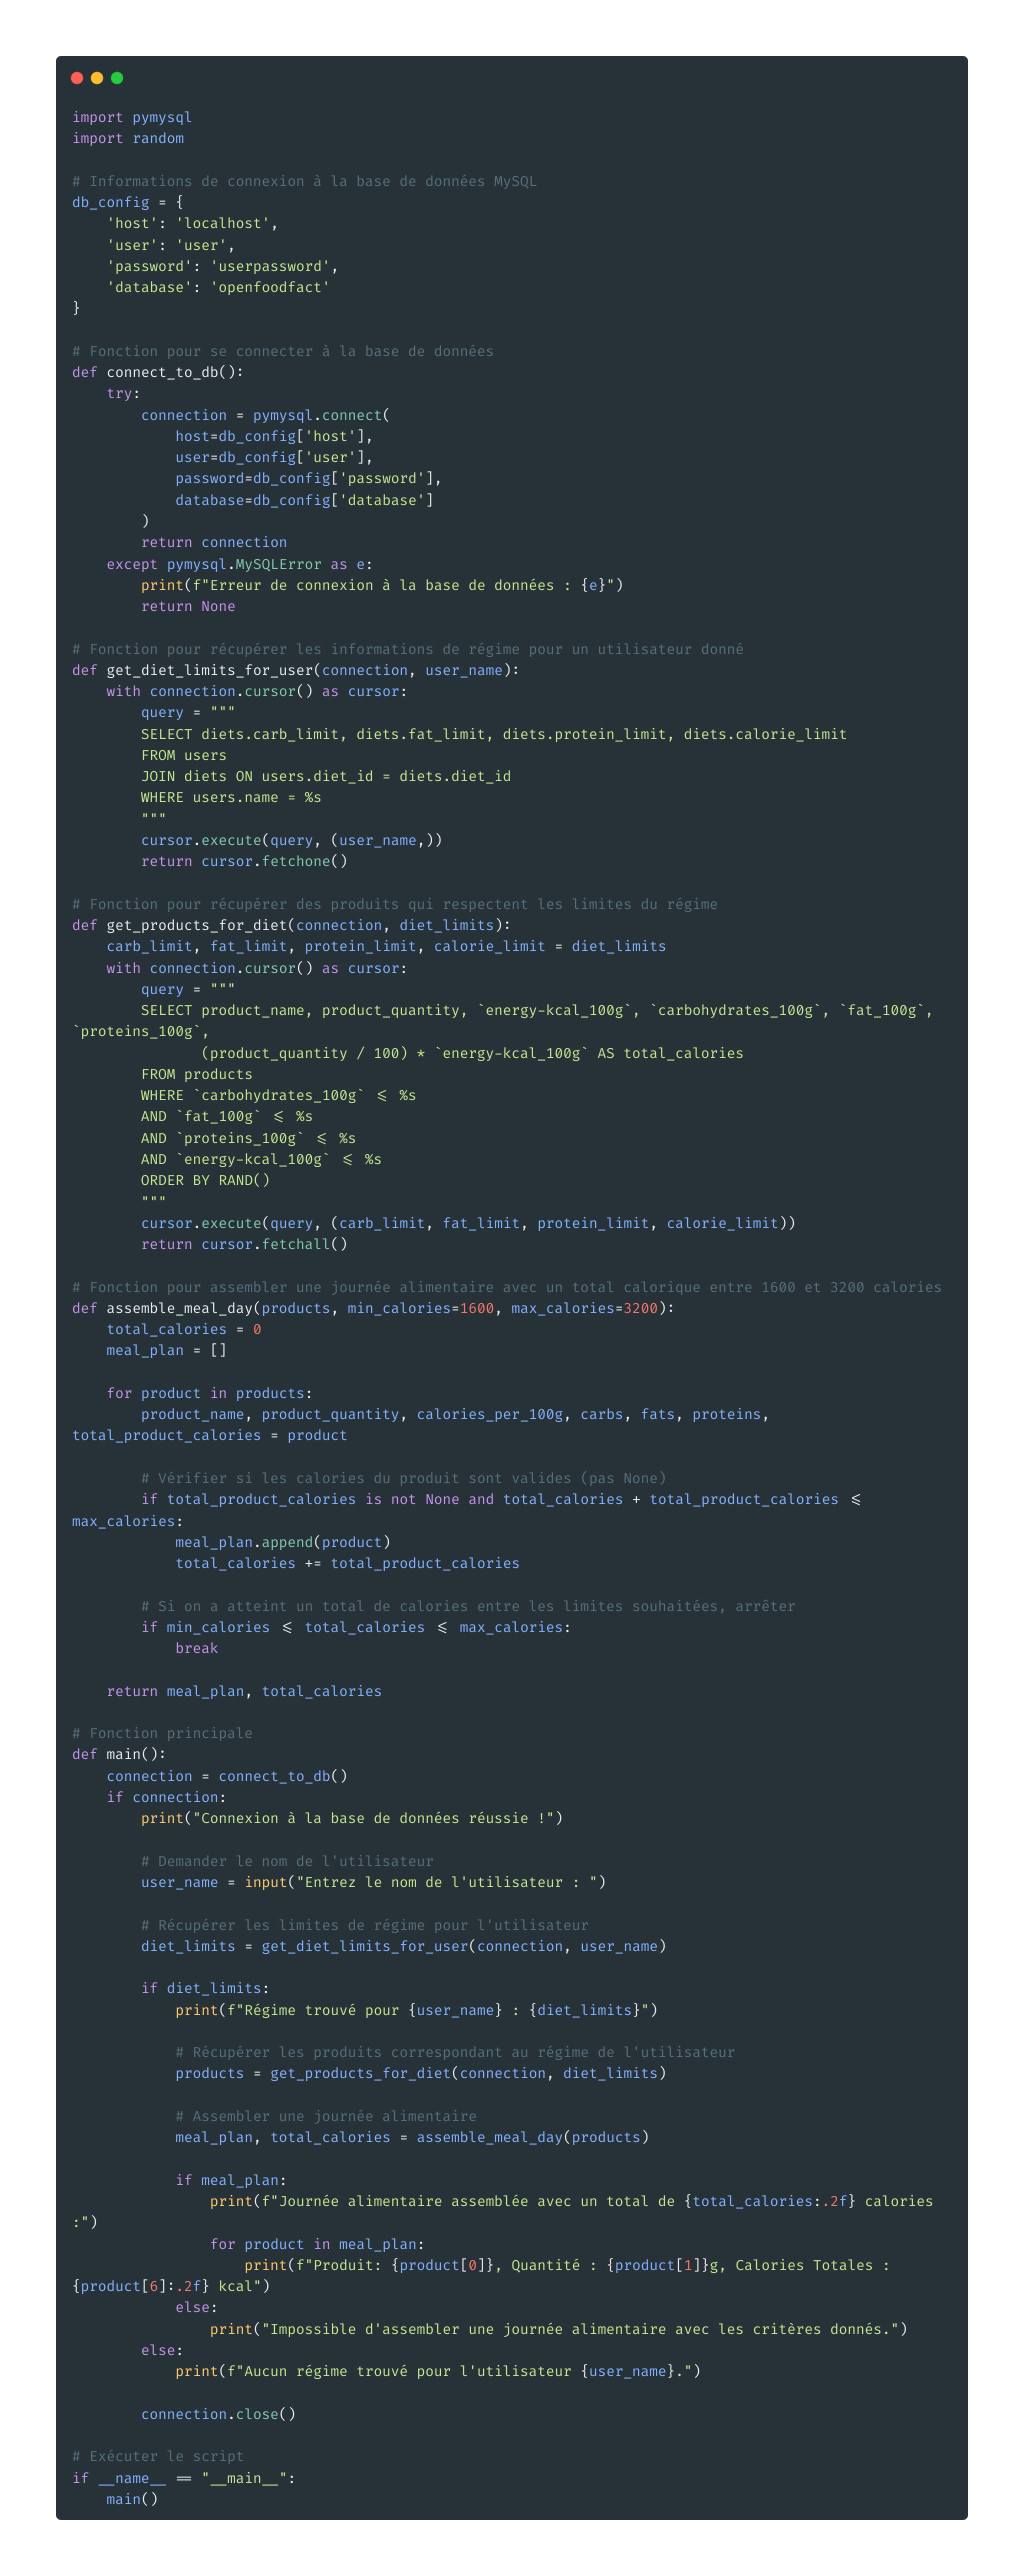

## Exemples de résultats de requêtes simples

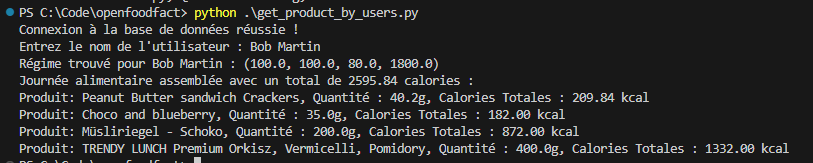

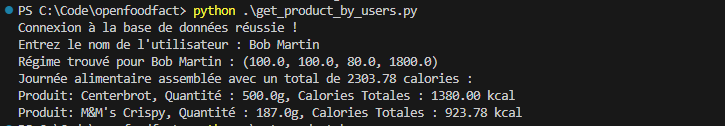